In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('data/train_merged.csv', parse_dates=['date'], low_memory=False)
test = pd.read_csv('data/test_merged.csv', parse_dates=['date'], low_memory=False)

In [3]:
train.earthquake.fillna('', inplace=True)
train.event_name.fillna('', inplace=True)
train.national_holiday.fillna('', inplace=True)
train.regional_holiday.fillna('', inplace=True)
train.local_holiday.fillna('', inplace=True)
train.work_day_name.fillna('', inplace=True)

test.earthquake.fillna('', inplace=True)
test.event_name.fillna('', inplace=True)
test.national_holiday.fillna('', inplace=True)
test.regional_holiday.fillna('', inplace=True)
test.local_holiday.fillna('', inplace=True)
test.work_day_name.fillna('', inplace=True)

In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,earthquake,event_name,national_holiday,regional_holiday,local_holiday,year,month,day,day_of_week,payday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False


In [5]:
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,transactions,...,earthquake,event_name,national_holiday,regional_holiday,local_holiday,year,month,day,day_of_week,payday
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False


In [6]:
%%time
cat_features = [
    'family', 'store_nbr', 'city', 'state', 'cluster',
    'earthquake', 'event_name', 'national_holiday', 'regional_holiday', 'local_holiday', 
    'payday', 'type', 'work_day_name',
]
for name in cat_features:
    print(f'Encode {name}')
    le = LabelEncoder()
    le.fit(train[name].unique())
    train[name] = le.transform(train[name])
    test[name] = le.transform(test[name])

Encode family
Encode store_nbr
Encode city
Encode state
Encode cluster
Encode earthquake
Encode event_name
Encode national_holiday
Encode regional_holiday
Encode local_holiday
Encode payday
Encode type
Encode work_day_name
Wall time: 4.71 s


In [7]:
dates = sorted(train.date.unique())
border_date = dates[-30]
train_data = train[train.date <= border_date]
valid_data = train[train.date > border_date]

print(train_data.shape)
print(valid_data.shape)

(2949210, 23)
(51678, 23)


In [8]:
train_dates = train_data.date.unique()
valid_dates = valid_data.date.unique()
print(f'Train from {train_dates[0]} to {train_dates[-1]}')
print(f'Valid from {valid_dates[0]} to {valid_dates[-1]}')

Train from 2013-01-01T00:00:00.000000000 to 2017-07-17T00:00:00.000000000
Valid from 2017-07-18T00:00:00.000000000 to 2017-08-15T00:00:00.000000000


In [9]:
y_train = np.log(train_data[['sales']].values + 1)
y_valid = np.log(valid_data[['sales']].values + 1)

X_train = train_data.drop(['id', 'sales', 'year', 'date', 'transactions'], axis=1)
X_valid = valid_data.drop(['id', 'sales', 'year', 'date', 'transactions'], axis=1)

X_test = test.drop(['id', 'date', 'year', 'transactions'], axis=1)

In [10]:
X_test.head()

,store_nbr,family,onpromotion,city,state,type,cluster,oil_price,work_day_name,earthquake,event_name,national_holiday,regional_holiday,local_holiday,month,day,day_of_week,payday
0,0,0,0,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0
1,0,1,0,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0
2,0,2,2,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0
3,0,3,20,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0
4,0,4,0,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0


In [50]:
xgb_params = {
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
    'predictor': 'cpu_predictor',
    'use_rmm': True,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 1,
    'learning_rate': 0.01,
    'subsample': 1,
    'max_depth': 7,
    'colsample_bytree': 1,
    'reg_alpha': 10,
    'reg_lambda': 1,
    'min_child_weight': 1,
}

In [84]:
%%time
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_valid = xgb.DMatrix(X_valid, label=y_valid)
eval_list = [(xgb_train, 'train'), (xgb_valid, 'eval')]
eval_result = dict()

model = xgb.train(
    params=xgb_params,
    dtrain=xgb_train,
    evals=eval_list,
    evals_result=eval_result,
    num_boost_round=10000,
    early_stopping_rounds=100,
    verbose_eval=False,
)

Wall time: 4min 24s


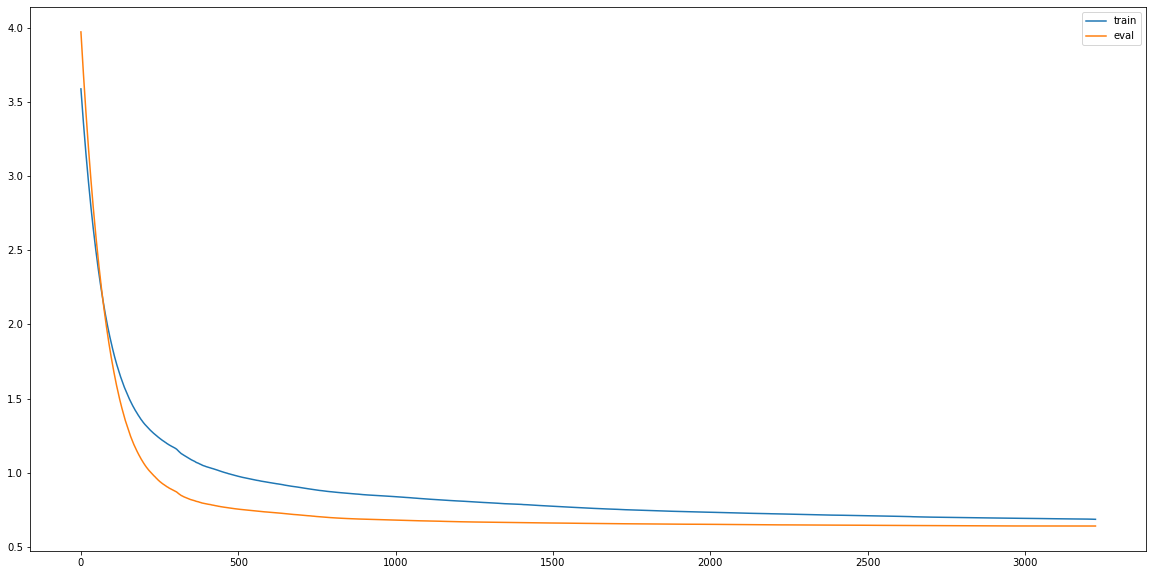

In [61]:
fig, ax = plt.subplots(figsize=(20, 10))
x = list(range(len(eval_result['eval']['rmse'])))
ax.plot(x, eval_result['train']['rmse'], label='train')
ax.plot(x, eval_result['eval']['rmse'], label='eval')
ax.legend(loc='upper right')
plt.show()

In [62]:
xgb_valid_pred = pd.Series(model.predict(xgb_valid)).map(lambda x: max(x, 0))
mean_squared_error(y_valid, xgb_valid_pred, squared=False)

0.635149333680264

In [81]:
valid_pred = valid_data.copy().reset_index()
valid_pred['sales_pred'] = xgb_valid_pred
valid_pred.groupby('family').apply(lambda x: mean_squared_error(x.sales, x.sales_pred, squared=False))

family
0        7.612754
1        0.527282
2        7.611124
3     4216.014422
4        0.205915
5      632.463219
6       17.973979
7     1506.671440
8     1020.025360
9      356.293643
10     250.458888
11     165.545156
12    5206.114877
13      47.362535
14       1.964644
15      37.475831
16      44.987740
17       0.632425
18     358.179305
19      15.623426
20      22.559225
21       9.572151
22     141.059142
23       9.466519
24     492.204950
25     379.729684
26      11.507051
27      14.670999
28     528.008646
29     108.004194
30    3168.254608
31     125.939789
32      30.696957
dtype: float64

In [82]:
sorted(model.get_fscore().items(), key=lambda x: x[1], reverse=True)

[('family', 131253),
 ('store_nbr', 57517),
 ('oil_price', 47563),
 ('month', 26109),
 ('onpromotion', 22283),
 ('cluster', 19948),
 ('type', 15843),
 ('day_of_week', 15558),
 ('city', 14774),
 ('state', 11862),
 ('day', 9451),
 ('national_holiday', 7359),
 ('earthquake', 2181),
 ('event_name', 2030),
 ('work_day_name', 571),
 ('local_holiday', 400),
 ('payday', 369),
 ('regional_holiday', 21)]

In [64]:
xgb_test = xgb.DMatrix(X_test)
xgb_pred = np.exp(pd.Series(model.predict(xgb_test)).map(lambda x: max(x, 0)))

In [65]:
pred = X_test.copy()
pred['sales'] = xgb_pred
pred.head()

,store_nbr,family,onpromotion,city,state,type,cluster,oil_price,work_day_name,earthquake,event_name,national_holiday,regional_holiday,local_holiday,month,day,day_of_week,payday,sales
0,0,0,0,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0,4.458143
1,0,1,0,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0,1.019869
2,0,2,2,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0,6.563096
3,0,3,20,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0,2459.753709
4,0,4,0,18,12,3,12,46.8,0,0,0,0,0,0,8,16,2,0,1.073568


In [66]:
for store_nbr in train.store_nbr.unique():
    for family in train.family.unique():
        cur_x = train[(train.store_nbr == store_nbr) & (train.family == family)]
        if not cur_x.sales.any():
            pred.loc[(pred.store_nbr == store_nbr) & (pred.family == family), 'sales'] = 0.0

In [67]:
sub = test[['id']].copy()
sub['sales'] = pred.sales
sub.head()

,id,sales
0,3000888,4.458143
1,3000889,0.000000
2,3000890,6.563096
3,3000891,2459.753709
4,3000892,1.073568


In [68]:
sub.to_csv('data/submission.csv', index=False)